# Udacity Self-Driving Car Engineering Nanodegree

## Deep Learning - CarND · T1 · P2 · Traffic Sign Classifier

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",

    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

----

## STEP 0 - Loading Data & Dependencies

### 0.1 - LOAD DEPENDENCIES

In [9]:
### Imports for later usage:

import csv
import cv2
import datetime
import math
import pickle
import random

import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.contrib.layers import flatten
from scipy import ndimage
from sklearn.utils import shuffle


### 0.2 - LOAD DATA

The pickled data is a dictionary with 4 key/value pairs:

- `features` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).

- `labels` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.

- `sizes` is a list containing tuples, (width, height) representing the original width and height the image.

- `coords` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image.

    **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**


In [10]:
# Load pickled data

# TODO: Fill this in based on where you saved the training and testing data

training_file = '../../data/train.p'
validation_file = '../../data/valid.p'
testing_file = '../../data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
    
    print('Opened %s' % training_file)
    
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
    
    print('Opened %s' % validation_file)
    
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
    print('Opened %s' % testing_file)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

Opened ../../data/train.p
Opened ../../data/valid.p
Opened ../../data/test.p


----

## STEP 1 - Dataset Summary & Exploration

### 1.1 - DATA BASIC SUMMARY

In [11]:
# Number of training, validation, testing and total examples:

n_train = len(y_train)
n_valid = len(y_valid)
n_test = len(y_test)
n_total = n_train + n_valid + n_test


# Image Data Shape:

train_shape = np.array(X_train).shape
image_shape = "%d px WIDTH × %d px HEIGHT × %d CHANNELS" % (train_shape[1], train_shape[2], train_shape[3])


# Unique classes:

classes = set(y_train) | set(y_valid) | set(y_test)
n_classes = len(classes)


# Find first ocurrence of each class:

found = 0

class_example_position = {}

for i in range(n_valid):
    c = y_valid[i]
    
    if c not in class_example_position:
        class_example_position[c] = i
        found = found + 1
        
        if found == n_classes:
            break

if found != n_classes: raise Exception('Examples for some classes not found. Please, search in the whole dataset.') 
            
        
# Print simple stats:

print("\nDATASETS STATS:")
print("-------------------------------------------------------------\n")

print("  TRAINING EXAMPLES = %6d (%6.2f %%)" % (n_train, 100.0 * n_train / n_total))
print("VALIDATION EXAMPLES = %6d (%6.2f %%)" % (n_valid, 100.0 * n_valid / n_total))
print("   TESTING EXAMPLES = %6d (%6.2f %%)" % (n_test, 100.0 * n_test / n_total))
print("---------------------------------------")
print("              TOTAL = %6d (100.00 %%)" % n_total)

print("\nDATA STATS:")
print("-------------------------------------------------------------\n")
print("   IMAGE DATA SHAPE =", image_shape)
print("     UNIQUE CLASSES =", n_classes)

print("\nCLASSES:")
print("-------------------------------------------------------------\n")

# Get the legend for each class:

labels = {}

with open("../../input/data/signnames.csv") as signnames_file:
    reader = csv.DictReader(signnames_file)

    for row in reader:
        class_id = row["ClassId"]
        class_name = row["SignName"]
        
        labels[class_id] = class_name
        
        print("%19s = %s" % (class_id, class_name))
        


DATASETS STATS:
-------------------------------------------------------------

  TRAINING EXAMPLES =  34799 ( 67.13 %)
VALIDATION EXAMPLES =   4410 (  8.51 %)
   TESTING EXAMPLES =  12630 ( 24.36 %)
---------------------------------------
              TOTAL =  51839 (100.00 %)

DATA STATS:
-------------------------------------------------------------

   IMAGE DATA SHAPE = 32 px WIDTH × 32 px HEIGHT × 3 CHANNELS
     UNIQUE CLASSES = 43

CLASSES:
-------------------------------------------------------------

                  0 = Speed limit (20km/h)
                  1 = Speed limit (30km/h)
                  2 = Speed limit (50km/h)
                  3 = Speed limit (60km/h)
                  4 = Speed limit (70km/h)
                  5 = Speed limit (80km/h)
                  6 = End of speed limit (80km/h)
                  7 = Speed limit (100km/h)
                  8 = Speed limit (120km/h)
                  9 = No passing
                 10 = No passing for vehicles over 3.5 

### 1.2 - EXPLORATORY VISUALIZATION

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

#### EXAMPLE IMAGES

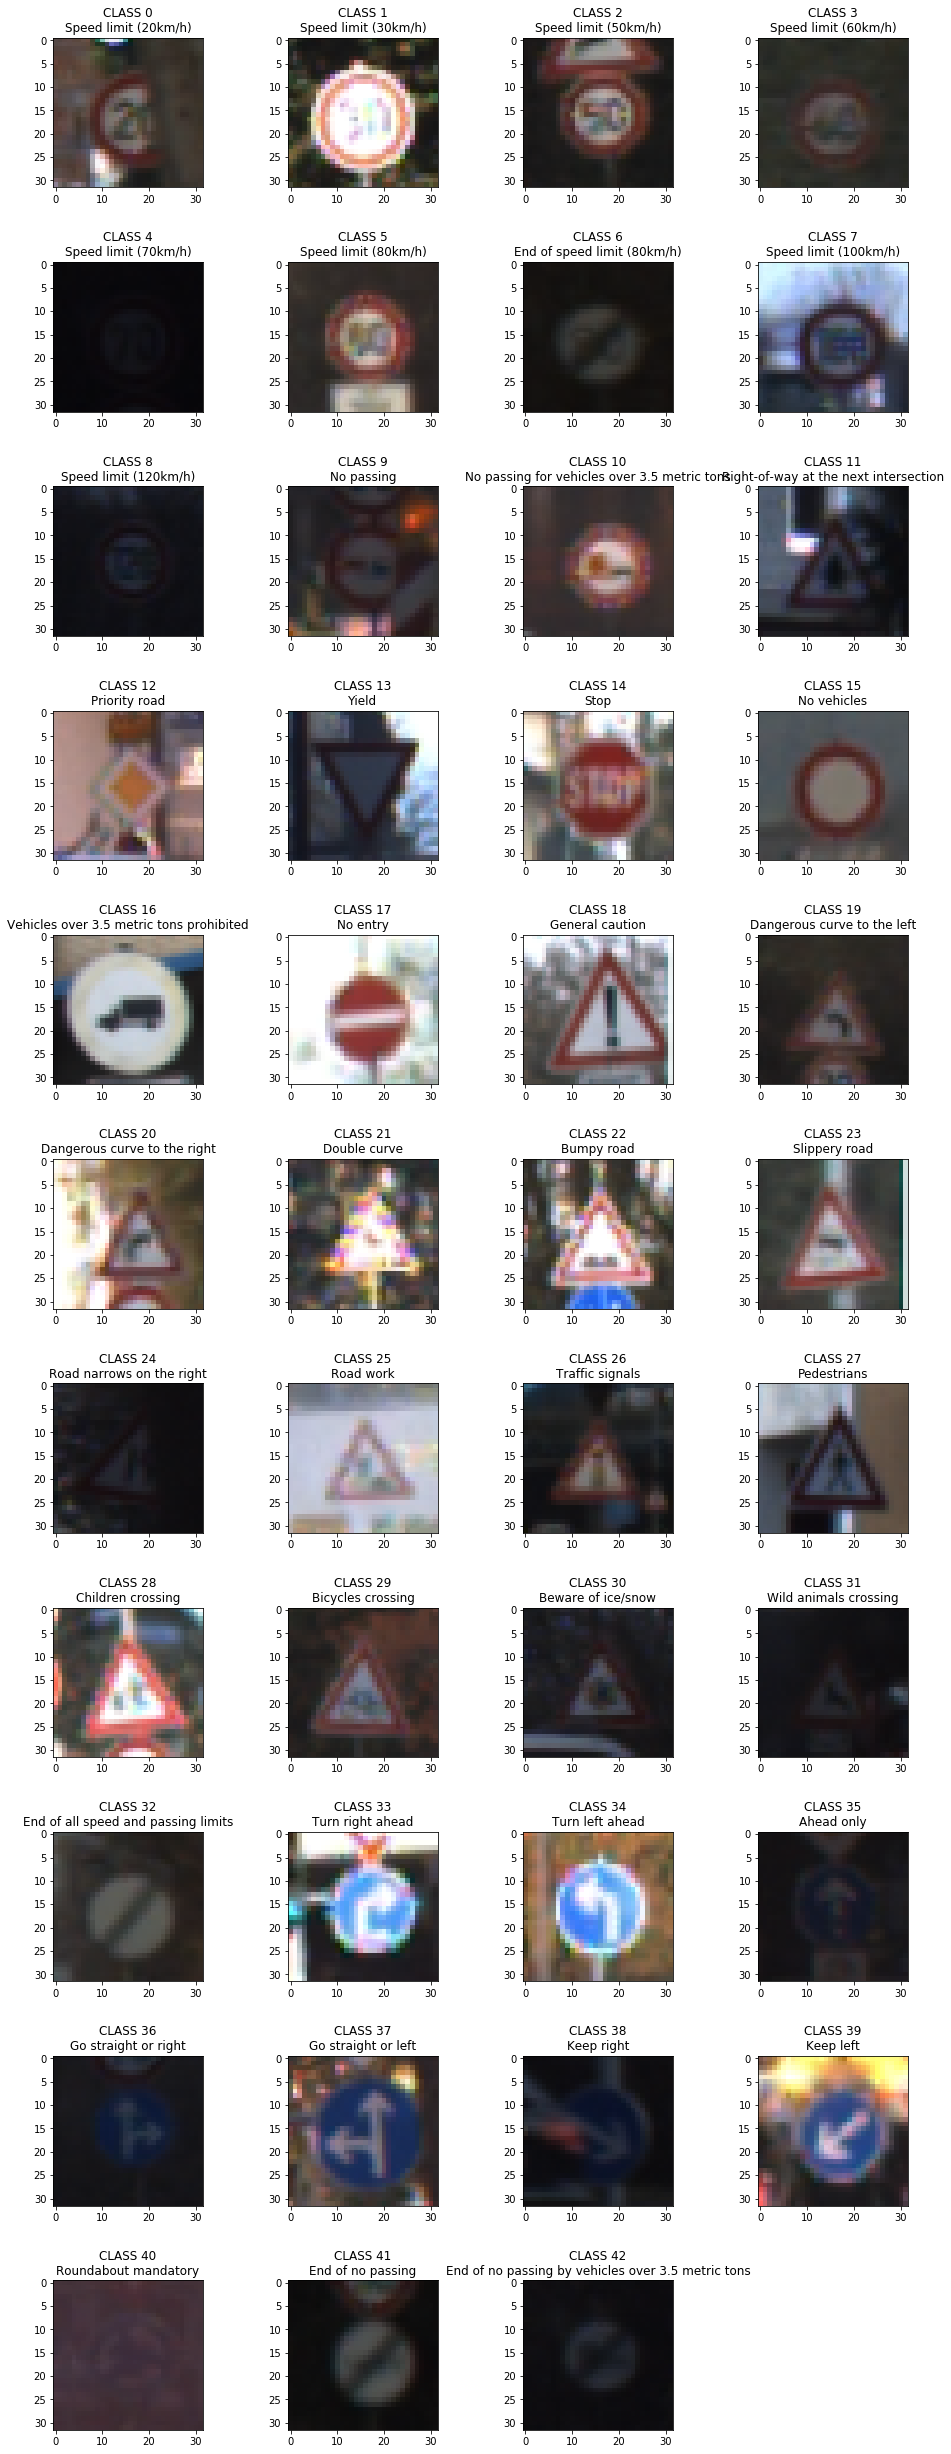

In [12]:
# Visualizations will be shown in the notebook:

%matplotlib inline


# Grid helper funcions:

def getGridFor(n_items, n_cols = 4):
    return getGrid(math.ceil(n_items / n_cols), n_cols)

def getGrid(n_rows, n_cols):
    plt.figure(figsize=(n_cols * 4, n_rows * 4))

    return gridspec.GridSpec(n_rows, n_cols, hspace=0.5, wspace=0.25) 
        
    
# Plot one example per class:

index = 0
n_cols = 4

gs = getGridFor(n_classes, n_cols)


for c in classes:
    ax = plt.subplot(gs[int(index / n_cols), index % n_cols])
    
    index = index  + 1
    
    ax.imshow(X_valid[class_example_position[c]])
        
    ax.set_title("CLASS %s\n%s" % (c, labels[str(c)]))


#### CLASSES DISTRIBUTION

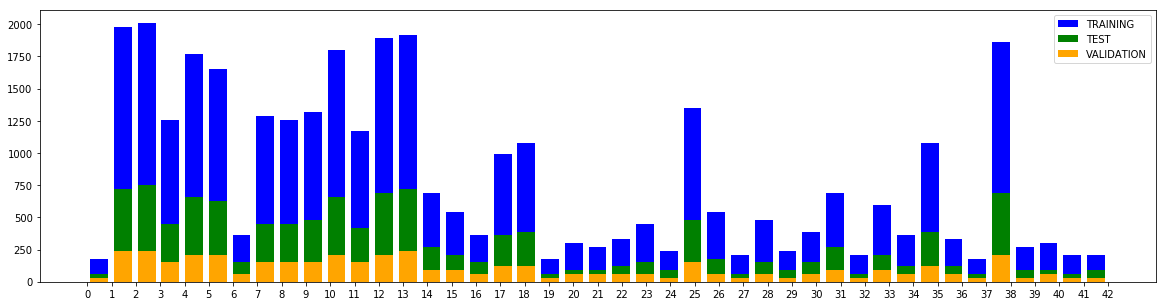

In [13]:
plt.figure(figsize=(20, 5))

plt.hist(y_train, bins = n_classes, label = "TRAINING", histtype="bar", color="BLUE", rwidth=0.75)
plt.hist(y_test, bins = n_classes, label = "TEST", histtype="bar", color="GREEN", rwidth=0.75)
plt.hist(y_valid, bins = n_classes, label = "VALIDATION", histtype="bar", color="ORANGE", rwidth=0.75)

plt.xticks(range(len(labels)))
plt.legend(loc="upper right")

plt.show()

----

## STEP 2 - Design & Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### 2.1 - IMAGE PROCESSING FUNCTIONS

To be used to preprocess the data sets as well as to augment them.

In [14]:
# Color Space Conversions: ####################################

# BGR to grayscale
def toGrayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


# Filters: ####################################################

# https://www.packtpub.com/mapt/book/Application+Development/9781785283932/2/ch02lvl1sec26/Enhancing+the+contrast+in+an+image

def contrast(img):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

    # equalize the histogram of the Y channel
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])

    # convert the YUV image back to RGB format
    return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

def hist(img):
    return cv2.equalizeHist(img)

def sharpen(img):
    return cv2.addWeighted(img, 2, cv2.GaussianBlur(img, (3, 3), 3), -1, 0)
    
def crop(img):   
    return img[2:30, 2:30]
    
    
# Normalization: ##############################################
# Normalizes the data between [-1, 1) instead of [0, 255]

def normalize(img):
    # im = np.asarray(img, dtype="float32")
    # im = (im - 128) / 128.0
    
    return (img / 255.0).astype(np.float32).reshape(28, 28, 1)

def normalize_set(images):
    return np.array([normalize(image) for image in images])

### 2.2 - PREPROCESS THE DATA SET

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

#### IMAGE PROCESSING PIPELINE DEMO

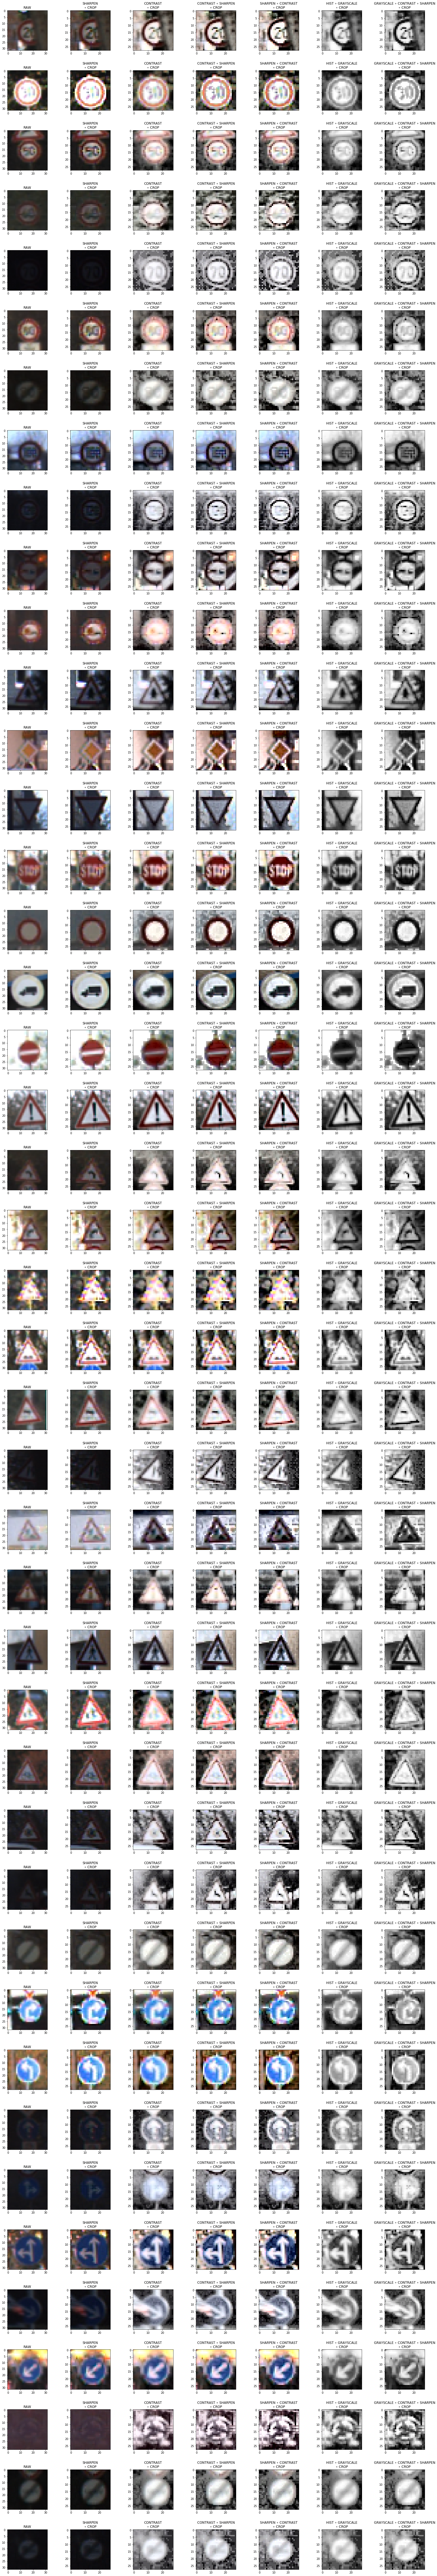

In [15]:
# examples = [100, 150, 200, 250, 1200, 1320, 19010] # In X_training

# Get first example per class:

examples = []

for c in classes:
    examples.append(class_example_position[c])
    

# Plot a few examples, step by step:

gs = getGrid(len(examples), 7)

row = 0

for i in examples:
    image = X_valid[i]
    
    sp = plt.subplot(gs[row, 0])
    sp.imshow(image)
    sp.set_title("RAW")

    sp = plt.subplot(gs[row, 1])
    sp.imshow(sharpen(crop(image)))
    sp.set_title("SHARPEN\n∘ CROP")

    sp = plt.subplot(gs[row, 2])
    sp.imshow(contrast(crop(image)))
    sp.set_title("CONTRAST\n∘ CROP")

    sp = plt.subplot(gs[row, 3])
    sp.imshow(contrast(sharpen(crop(image))))
    sp.set_title("CONTRAST ∘ SHARPEN\n∘ CROP")

    sp = plt.subplot(gs[row, 4])
    sp.imshow(sharpen(contrast(crop(image))))
    sp.set_title("SHARPEN ∘ CONTRAST\n∘ CROP")

    sp = plt.subplot(gs[row, 5])
    sp.imshow(hist(toGrayscale(crop(image))), cmap='gray')
    sp.set_title("HIST ∘ GRAYSCALE\n∘ CROP")

    sp = plt.subplot(gs[row, 6])
    sp.imshow(toGrayscale(contrast(sharpen(crop(image)))), cmap='gray')
    sp.set_title("GRAYSCALE ∘ CONTRAST ∘ SHARPEN\n∘ CROP")
    
    row = row + 1

#### IMAGE PROCESSING PIPELINE

In [16]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

def prepare(images):
    # return np.array(list(map(lambda img: hist(toGrayscale(crop(img))), images)))
    return np.array(list(map(lambda img: toGrayscale(contrast(sharpen(crop(img)))), images)))


# Preprocess all the images:   

print("Processing Training Set...")
X_train_pre = prepare(X_train)
assert(len(X_train) == len(X_train_pre))
assert(X_train_pre.shape == (n_train, 28, 28))

print("Processing Validation Set...")
X_valid_pre = prepare(X_valid)
assert(len(X_valid_pre) == len(X_valid))
assert(X_valid_pre.shape == (n_valid, 28, 28))

print("Processing Testing Set...")
X_test_pre = prepare(X_test)
assert(len(X_test_pre) == len(X_test))
assert(X_test_pre.shape == (n_test, 28, 28))

Processing Training Set...
Processing Validation Set...
Processing Testing Set...


### 2.3 - TRAINING SET AUGMENTATION

#### AUGMENTATION FUNCTION

In [17]:
transformation = -1

angles = [-5, 5, -10, 10, -15, 15, -20, 20, -25, 25]

def transform(source_img):
    global transformation

    transformation = (transformation + 1) % 4
    
    img = np.copy(source_img)
    
    img = ndimage.rotate(img, random.choice(angles), reshape=False)
        
    if transformation in [1, 3]:
        img = sharpen(img)
        
    if transformation in [2, 3]:    
        im = np.asarray(img, dtype="int32")
        im = im + random.randrange(-10, 10)
        np.clip(im, 0, 255, out=im)
        
        img = im.astype('uint8')
        
    return img

#### AUGMENTATION EXAMPLE

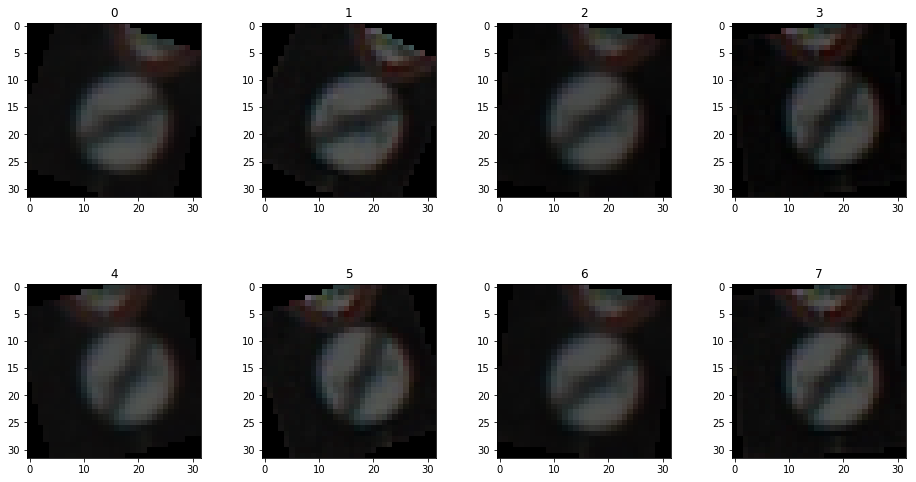

In [18]:
testImage = X_valid[0]

gs = getGrid(2, 4)

for i in range(8):
    sp = plt.subplot(gs[i//4, i%4])
    sp.imshow(transform(testImage))
    sp.set_title(i)

#### TRAINING DATA SET AUGMENTATION

In [19]:
X_train_aug = np.copy(X_train_pre)
y_train_aug = np.copy(y_train)

_, counts = np.unique(y_train, return_counts=True)

print("Augmenting data...")

for c in classes:
    # Ocurrences for the current class:
    count = counts[c]

    # How many more we want:
    # remaining = (1000 if count < 1000 else 1500 if count < 1500 else 2100) - count
    # remaining = 2100 - count
    remaining = (1500 if count < 1500 else 2100) - count
    
    # Augment labels: 
    y_train_aug = np.append(y_train_aug, np.repeat(c, remaining)) 
    
    # Get n = remaining random images with the current class to use as a base image to generate new ones:
    base_images_indices = np.random.choice(np.where(y_train == c)[0], remaining)
                
    # Augment images:        
    X_train_aug = np.append(X_train_aug, np.array([transform(img) for img in X_train_pre[base_images_indices]]), axis = 0)
        
    assert(len(y_train_aug) == len(X_train_aug))
    
    print("Finished with class %d" % c)

    
print("Data augmented.")


Augmenting data...
Finished with class 0
Finished with class 1
Finished with class 2
Finished with class 3
Finished with class 4
Finished with class 5
Finished with class 6
Finished with class 7
Finished with class 8
Finished with class 9
Finished with class 10
Finished with class 11
Finished with class 12
Finished with class 13
Finished with class 14
Finished with class 15
Finished with class 16
Finished with class 17
Finished with class 18
Finished with class 19
Finished with class 20
Finished with class 21
Finished with class 22
Finished with class 23
Finished with class 24
Finished with class 25
Finished with class 26
Finished with class 27
Finished with class 28
Finished with class 29
Finished with class 30
Finished with class 31
Finished with class 32
Finished with class 33
Finished with class 34
Finished with class 35
Finished with class 36
Finished with class 37
Finished with class 38
Finished with class 39
Finished with class 40
Finished with class 41
Finished with class 42
Da

#### 2.3.2 - NEW CLASSES DISTRIBUTION

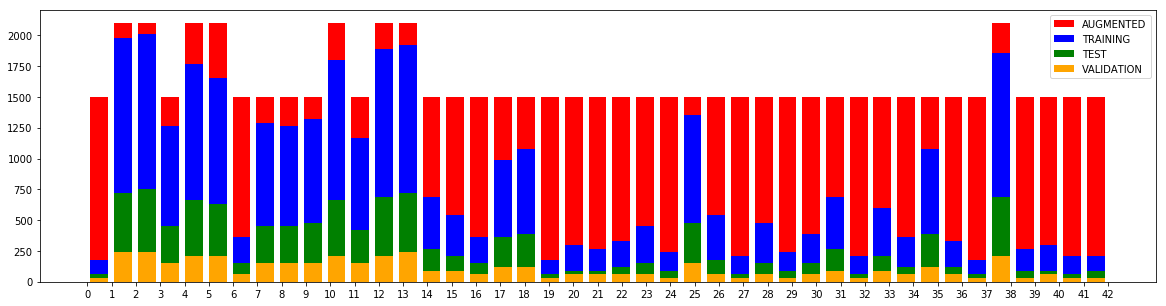

In [20]:
plt.figure(figsize=(20, 5))

plt.hist(y_train_aug, bins = n_classes, label = "AUGMENTED", histtype="bar", color="RED", rwidth=0.75)
plt.hist(y_train, bins = n_classes, label = "TRAINING", histtype="bar", color="BLUE", rwidth=0.75)
plt.hist(y_test, bins = n_classes, label = "TEST", histtype="bar", color="GREEN", rwidth=0.75)
plt.hist(y_valid, bins = n_classes, label = "VALIDATION", histtype="bar", color="ORANGE", rwidth=0.75)

plt.xticks(range(len(labels)))
plt.legend(loc="upper right")

plt.show()

### 2.4 - DATA NORMALIZATION

In [21]:
# Preprocess all the images:   

n_train_augmented = len(y_train_aug)

print("Processing Training Set...")
X_train_aug = normalize_set(X_train_aug)
assert(len(X_train_aug) == n_train_augmented)
assert(X_train_aug.shape == (n_train_augmented, 28, 28, 1))

print("Processing Validation Set...")
X_valid_pre = normalize_set(X_valid_pre)
assert(len(X_valid_pre) == len(X_valid))
assert(X_valid_pre.shape == (n_valid, 28, 28, 1))

print("Processing Testing Set...")
X_test_pre = normalize_set(X_test_pre)
assert(len(X_test_pre) == len(X_test))
assert(X_test_pre.shape == (n_test, 28, 28, 1))

Processing Training Set...
Processing Validation Set...
Processing Testing Set...


### MODEL ARCHITECTURE

#### HELPER FUNCTIONS:

In [22]:
def conv2d(x, W, b, padding='SAME', strides=1):
    x = tf.nn.bias_add(tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding=padding), b)
    
    return tf.nn.relu(x)
  
def maxpool2d(x, k=2, padding='SAME'):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding=padding)    

#### LeNet IMPLEMENTATION:


In [23]:
def MyNet(x, keep_prob):
    weights = {
        'w_conv1': tf.get_variable('w_conv1', shape=[7, 7, 1, 64], initializer=tf.contrib.layers.xavier_initializer()),
        'w_conv2': tf.get_variable('w_conv2', shape=[5, 5, 64, 128], initializer=tf.contrib.layers.xavier_initializer()),
        'w_conv3': tf.get_variable('w_conv3', shape=[3, 3, 128, 256], initializer=tf.contrib.layers.xavier_initializer()),
        'w_fc1': tf.get_variable('w_fc1', shape=[6400, 256], initializer=tf.contrib.layers.xavier_initializer()),
        'w_fc2': tf.get_variable('w_fc2', shape=[256, 128], initializer=tf.contrib.layers.xavier_initializer()),
        'w_fc3': tf.get_variable('w_fc3', shape=[128, n_classes], initializer=tf.contrib.layers.xavier_initializer())
    }

    biases = {
        'b_conv1': tf.get_variable('b_conv1', initializer=tf.zeros(64)),
        'b_conv2': tf.get_variable('b_conv2', initializer=tf.zeros(128)),
        'b_conv3': tf.get_variable('b_conv3', initializer=tf.zeros(256)),
        'b_fc1': tf.get_variable('b_fc1', initializer=tf.zeros(256)),
        'b_fc2': tf.get_variable('b_fc2', initializer=tf.zeros(128)),
        'b_fc3': tf.get_variable('b_fc3', initializer=tf.zeros(n_classes)),
    }
    
    # STEP 1:    Convolutional + Relu + Pooling    + Dropout
    # DIMENSIONS: 28x28x1       → 28x28x64          → 14x14x64
    conv1 = maxpool2d(conv2d(x, weights['w_conv1'], biases['b_conv1']))
    conv1 = tf.nn.dropout(conv1, keep_prob)
    
    # STEP 2:    Convolutional + Relu + Pooling    + Dropout
    # DIMENSIONS: 14x14x64      → 14x14x128         → 7x7x128
    conv2 = maxpool2d(conv2d(conv1, weights['w_conv2'], biases['b_conv2']))
    conv2 = tf.nn.dropout(conv2, keep_prob)
    
    # STEP 3:    Convolutional + Relu + Dropout
    # DIMENSIONS: 7x7x128       → 5x5x256
    conv3 = conv2d(conv2, weights['w_conv3'], biases['b_conv3'], 'VALID')
    conv3 = tf.nn.dropout(conv3, keep_prob)
        
    # STEP 4: FLATTEN:
    # DIMENSIONS: 5x5x256 → 6400
    fc0 = flatten(conv3)
    
    # STEP 5:    Fully Connected + Relu
    # DIMENSIONS: 6400 → 256
    fc1 = tf.matmul(fc0, weights['w_fc1']) + biases['b_fc1']
    fc1 = tf.nn.dropout(fc1, keep_prob)
        
    # STEP 6:     Fully Connected + Relu
    # DIMENSIONS: 256 → 128
    fc2 = tf.matmul(fc1, weights['w_fc2']) + biases['b_fc2']
    fc2 = tf.nn.dropout(fc2, keep_prob)
        
    # STEP 7:     Fully Connected + Relu
    # DIMENSIONS: 128 → n_classes = 43
    fc3 = tf.matmul(fc2, weights['w_fc3']) + biases['b_fc3']
    
    # RETURN ALL:
    return fc3, {
        "conv1": conv1,
        "conv2": conv2,
        "conv3": conv3,
        "fc0": fc0,
        "fc1": fc1,
        "fc2": fc2,
        "fc3": fc3
    }
    

### TRAIN, VALIDATE & TEST THE MODEL

A validation set can be used to assess how well the model is performing:
- A low accuracy on the training and validation sets imply underfitting.
- A high accuracy on the training set but low accuracy on the validation set implies overfitting.

 

#### HYPERPARAMS

In [24]:
MODEL_FILE = '../../models/traffic-sign-classifier-model.ckpt'

# Not used as we are using Xavier initialization.
# See: https://www.tensorflow.org/api_docs/python/tf/contrib/layers/xavier_initializer
# See: https://prateekvjoshi.com/2016/03/29/understanding-xavier-initialization-in-deep-neural-networks/

# mu = 0
# sigma = 0.1

# Let's try to speed up the learning using rate = 0.05 instead of rate = 0.001.
# If it doesn't work, we can always re-run it again using another value, although anyway this is just an initial value.
# AdaGrad or Adam Optimizers will take care of updating it. Maybe Momentum could take more time to converge but lead
# to more accurate models.
# See: http://int8.io/comparison-of-optimization-techniques-stochastic-gradient-descent-momentum-adagrad-and-adadelta/#AdaGrad_8211_experiments

# RATE = 0.001
# RATE = 0.005
RATE = 0.05

# Keep probability for dropout to prevent overfitting:

KEEP_PROB = 0.75
KEEP_PROB = 0.65
KEEP_PROB = 0.5
KEEP_PROB = 0.55
KEEP_PROB = 0.6

# Batch size:

BATCH_SIZE = 196
BATCH_SIZE = 256

# Convergence:

EPOCHS = 64
TARGET = 1.00

# Tries:

# EPOCHS = 16, RATE = 0.050000, KEEP_PROB = 0.500000, BATCH_SIZE = 196  -  0.964 VAL. ACCURACY, 0.948 IN TEST (underfit)
# EPOCHS = 16, RATE = 0.050000, KEEP_PROB = 0.500000, BATCH_SIZE = 256  -  0.977 VAL. ACCURACY, 0.949 IN TEST (underfit)

# EPOCHS = 16, RATE = 0.050000, KEEP_PROB = 0.750000, BATCH_SIZE = 196  -  0.962 VAL. ACCURACY, 0.949 IN TEST (overfit)
# EPOCHS = 16, RATE = 0.050000, KEEP_PROB = 0.750000, BATCH_SIZE = 256  -  0.968 VAL. ACCURACY, 0.949 IN TEST (overfit)

# EPOCHS = 32, RATE = 0.050000, KEEP_PROB = 0.750000, BATCH_SIZE = 256  -  0.971 VAL. ACCURACY, 0.955 IN TEST (overfit)

# Bigger augmentation:

# EPOCHS = 32, RATE = 0.050000, KEEP_PROB = 0.750000, BATCH_SIZE = 256  -  0.973 VAL. ACCURACY, 0.952 IN TEST (overfit)

# Different preprocessing:

# EPOCHS = 32, RATE = 0.050000, KEEP_PROB = 0.750000, BATCH_SIZE = 256  -  0.975 VAL. ACCURACY, 0.954 IN TEST (overfit)
# EPOCHS = 32, RATE = 0.050000, KEEP_PROB = 0.650000, BATCH_SIZE = 256  -  0.979 VAL. ACCURACY, 0.958 IN TEST (overfit)
# EPOCHS = 32, RATE = 0.050000, KEEP_PROB = 0.500000, BATCH_SIZE = 256  -  0.980 VAL. ACCURACY, 0.956 IN TEST (underfit)
# EPOCHS = 32, RATE = 0.050000, KEEP_PROB = 0.550000, BATCH_SIZE = 256  -  0.981 VAL. ACCURACY, 0.960 IN TEST (underfit)
# EPOCHS = 32, RATE = 0.050000, KEEP_PROB = 0.600000, BATCH_SIZE = 256  -  0.985 VAL. ACCURACY, 0.961 IN TEST (GREAT!)

# EPOCHS = 64, RATE = 0.050000, KEEP_PROB = 0.600000, BATCH_SIZE = 256  -  0.984 VAL. ACCURACY, 0.967 IN TEST (EVEN BETTER!)

#### NETS

In [25]:
tf.reset_default_graph()

# INPUT:

x = tf.placeholder(tf.float32, (None, 28, 28, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, n_classes)


# OUTPUT:

logits, layers = MyNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
# optimizer = tf.train.AdamOptimizer(learning_rate = RATE)
optimizer = tf.train.AdagradOptimizer(learning_rate = RATE)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    
    for offset in range(0, num_examples, BATCH_SIZE):
        end = offset + BATCH_SIZE
        batch_x, batch_y = X_data[offset:end], y_data[offset:end]
        accuracy = sess.run(accuracy_operation, feed_dict = {x: batch_x, y: batch_y, keep_prob: 1.0 })
        total_accuracy += (accuracy * len(batch_x))
        
    return total_accuracy / num_examples

#### TRAIN THE MODEL (TRAINING AND VALIDATION ACCURACIES)


TRAINING...
------------------------
     EPOCHS LIMIT =   64
VALIDATION TARGET = 1.00


2017-11-07 16:59:42.255958 | TRAINING EPOCH 1 / 64...
2017-11-07 17:00:23.706434 | DONE TRAINING | 0:00:41.450476
  Training Accuracy = 0.754
Validation Accuracy = 0.751


2017-11-07 17:00:36.613341 | TRAINING EPOCH 2 / 64...
2017-11-07 17:01:14.524199 | DONE TRAINING | 0:00:37.910858
  Training Accuracy = 0.934
Validation Accuracy = 0.916


2017-11-07 17:01:27.327173 | TRAINING EPOCH 3 / 64...
2017-11-07 17:02:05.236659 | DONE TRAINING | 0:00:37.909486
  Training Accuracy = 0.956
Validation Accuracy = 0.941


2017-11-07 17:02:18.032332 | TRAINING EPOCH 4 / 64...
2017-11-07 17:02:55.938508 | DONE TRAINING | 0:00:37.906176
  Training Accuracy = 0.970
Validation Accuracy = 0.949


2017-11-07 17:03:08.732877 | TRAINING EPOCH 5 / 64...
2017-11-07 17:03:46.632863 | DONE TRAINING | 0:00:37.899986
  Training Accuracy = 0.983
Validation Accuracy = 0.964


2017-11-07 17:03:59.439389 | TRAINING EPOCH 6 / 64

2017-11-07 17:40:07.038504 | DONE TRAINING | 0:00:37.902085
  Training Accuracy = 1.000
Validation Accuracy = 0.983


2017-11-07 17:40:19.833198 | TRAINING EPOCH 49 / 64...
2017-11-07 17:40:57.747550 | DONE TRAINING | 0:00:37.914352
  Training Accuracy = 1.000
Validation Accuracy = 0.980


2017-11-07 17:41:10.542311 | TRAINING EPOCH 50 / 64...
2017-11-07 17:41:48.453365 | DONE TRAINING | 0:00:37.911054
  Training Accuracy = 1.000
Validation Accuracy = 0.983


2017-11-07 17:42:01.249721 | TRAINING EPOCH 51 / 64...
2017-11-07 17:42:39.172051 | DONE TRAINING | 0:00:37.922330
  Training Accuracy = 1.000
Validation Accuracy = 0.982


2017-11-07 17:42:51.974062 | TRAINING EPOCH 52 / 64...
2017-11-07 17:43:29.885633 | DONE TRAINING | 0:00:37.911571
  Training Accuracy = 1.000
Validation Accuracy = 0.985


2017-11-07 17:43:42.677530 | TRAINING EPOCH 53 / 64...
2017-11-07 17:44:20.579869 | DONE TRAINING | 0:00:37.902339
  Training Accuracy = 1.000
Validation Accuracy = 0.984


2017-11-07 17:44:

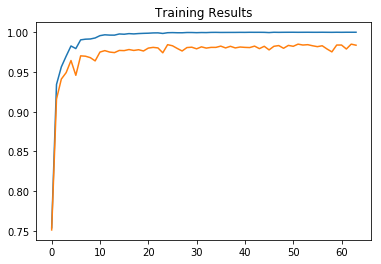

In [26]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

# PLOT DATA:

training_accuracies = []
validation_accuracies = []


# LET'S TRAIN!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    num_examples = len(X_train_aug)
    
    print("\nTRAINING...")
    print("------------------------")
    print("     EPOCHS LIMIT = %4d" % EPOCHS)
    print("VALIDATION TARGET = %1.2f" % TARGET)
    
    i = 0
    validation_accuracy = 0
    
    while i < EPOCHS and validation_accuracy < TARGET:
        start = datetime.datetime.now()
        
        print("\n\n%s | TRAINING EPOCH %d / %d..." % (start, i + 1, EPOCHS))
        
        X_train_aug, y_train_aug = shuffle(X_train_aug, y_train_aug)
        
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_aug[offset:end], y_train_aug[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: KEEP_PROB })
        
        end = datetime.datetime.now()
        
        print("%s | DONE TRAINING | %s" % (end, end - start))
        
        training_accuracy = evaluate(X_train_aug, y_train_aug)
        training_accuracies.append(training_accuracy)
        print("  Training Accuracy = %3.3f" % training_accuracy)
        
        validation_accuracy = evaluate(X_valid_pre, y_valid)
        validation_accuracies.append(validation_accuracy)
        print("Validation Accuracy = %3.3f" % validation_accuracy)
        
        i = i + 1
    
    save_path = saver.save(sess, MODEL_FILE)
    
    print("\n\nModel saved in file: %s\n" % save_path)
    
plt.plot(training_accuracies)
plt.plot(validation_accuracies)
plt.title("Training Results")
plt.show()

#### TEST ACCURACY

In [27]:
with tf.Session() as session:
    saver.restore(session, MODEL_FILE)
    
    test_accuracy = evaluate(X_test_pre, y_test)
    
    print("TEST ACCURACY: %3.3f" % test_accuracy)

TEST ACCURACY: 0.967


---

## STEP 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

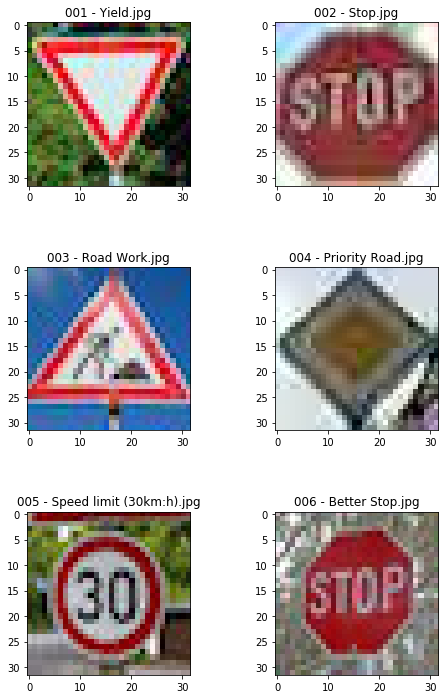

In [31]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

import os
import matplotlib.image as mpimg


# Get all the test images:

imagesDir = "../../input/images/resized/"
imagesNames = os.listdir(imagesDir)
imagesNames.sort()
imagesCount = len(imagesNames)
images = list(map(lambda imageName: mpimg.imread(imagesDir + imageName), imagesNames))


# Plot them:

n_cols = 2
gs = getGridFor(imagesCount, n_cols)

index = 0

for imageName in imagesNames:
    ax = plt.subplot(gs[int(index / n_cols), index % n_cols])
    
    ax.imshow(images[index])
    
    index = index  + 1
        
    ax.set_title(imageName)

### Predict the Sign Type for Each Image

In [32]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

ACTUAL_SIGNS = ["Yield", "Stop", "Road work", "Priority road", "Speed limit (30km/h)", "Stop"]

extraPreproc = normalize_set(prepare(images))

with tf.Session() as session:
    saver.restore(session, MODEL_FILE)
    
    prob = tf.nn.softmax(logits)
    top_5 = tf.nn.top_k(prob, k=5)

    res = session.run(top_5, feed_dict={ x: extraPreproc, keep_prob: 1.0 })
    
    tagsOk = []
    
    for (i, tagIndex) in enumerate(res.indices[:, 0]):
        tagPredicted = labels[str(tagIndex)]
        tagActual = ACTUAL_SIGNS[i]
        tagOk = tagPredicted == tagActual
        tagsOk.append(tagOk)
        
        if tagOk:
            print("%d OK. Predicted: %s" % (i + 1, tagPredicted))
        else:
            print("%d WRONG. Predicted: %s but was: %s" % (i + 1, tagPredicted, tagActual))

1 OK. Predicted: Yield
2 WRONG. Predicted: Yield but was: Stop
3 OK. Predicted: Road work
4 OK. Predicted: Priority road
5 OK. Predicted: Speed limit (30km/h)
6 OK. Predicted: Stop


### Analyze Performance

In [35]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

print("Performance with all 6 images: %f" % (sum(tagsOk) / imagesCount))

Performance with all 6 images: 0.833333


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.


001 - Yield.jpg: 
      1.000000 Yield
      0.000000 Priority road
      0.000000 Keep right
      0.000000 Speed limit (60km/h)
      0.000000 No vehicles

002 - Stop.jpg: 
      0.464415 Yield
      0.407376 Stop
      0.049386 Speed limit (60km/h)
      0.037694 Speed limit (70km/h)
      0.015160 Speed limit (80km/h)

003 - Road Work.jpg: 
      0.999183 Road work
      0.000692 Beware of ice/snow
      0.000073 Bumpy road
      0.000030 Wild animals crossing
      0.000007 Speed limit (80km/h)

004 - Priority Road.jpg: 
      0.942039 Priority road
      0.057961 Roundabout mandatory
      0.000000 End of no passing by vehicles over 3.5 metric tons
      0.000000 No entry
      0.000000 Keep right

005 - Speed limit (30km:h).jpg: 
      1.000000 Speed limit (30km/h)
      0.000000 Speed limit (20km/h)
      0.000000 Speed limit (70km/h)
      0.000000 Speed limit (50km/h)
      0.000000 End of speed limit (80km/h)

006 - Better Stop.jpg: 
      1.000000 Stop
      0.000000 Yield

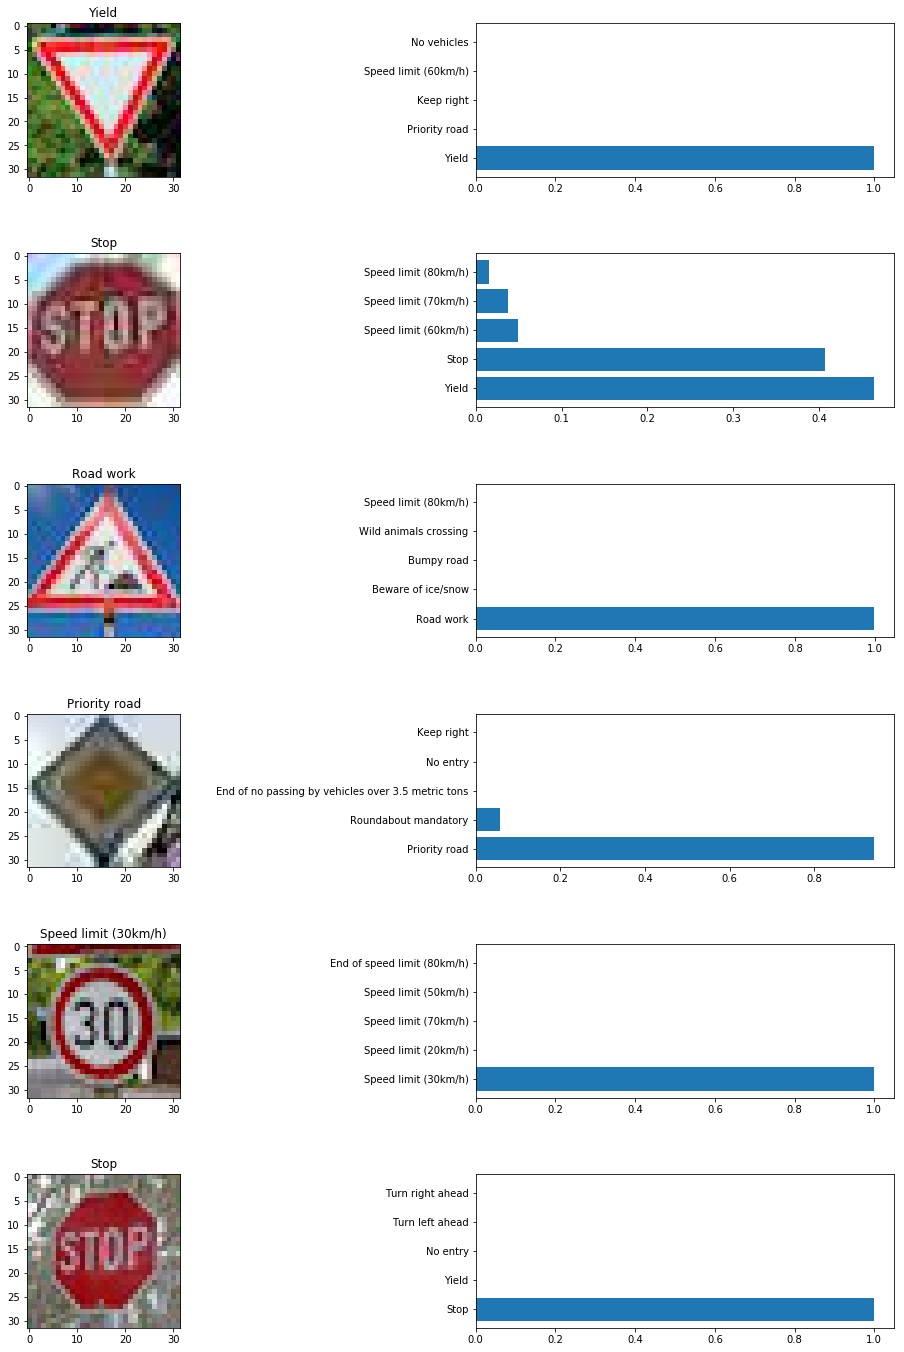

In [37]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

for (i, imageName) in enumerate(imagesNames):
    print("\n%s: " % imageName)

    for (j, tagIndex) in enumerate(res.indices[i]):
        tagName = labels[str(tagIndex)]
        
        print("      %f %s" % (res.values[i, j], tagName))

plt.figure(figsize=(15, 15))

gs = getGrid(len(images), 5)

for i in range(imagesCount):
    ax = plt.subplot(gs[i, 1])
    ax.imshow(images[i]) 
    ax.set_title(ACTUAL_SIGNS[i])
    
    yLabels = [labels[str(j)] for j in res.indices[i]]
    ax = plt.subplot(gs[i, 3:])
    ax.barh(range(1, 6), res.values[i, :])
    ax.set_yticks(range(1, 6))
    ax.set_yticklabels(yLabels)
    
plt.show()



### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [52]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1, plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess, feed_dict={x: image_input, keep_prob: 1})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,20))
    for featuremap in range(featuremaps):
        plt.subplot(16,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
                       

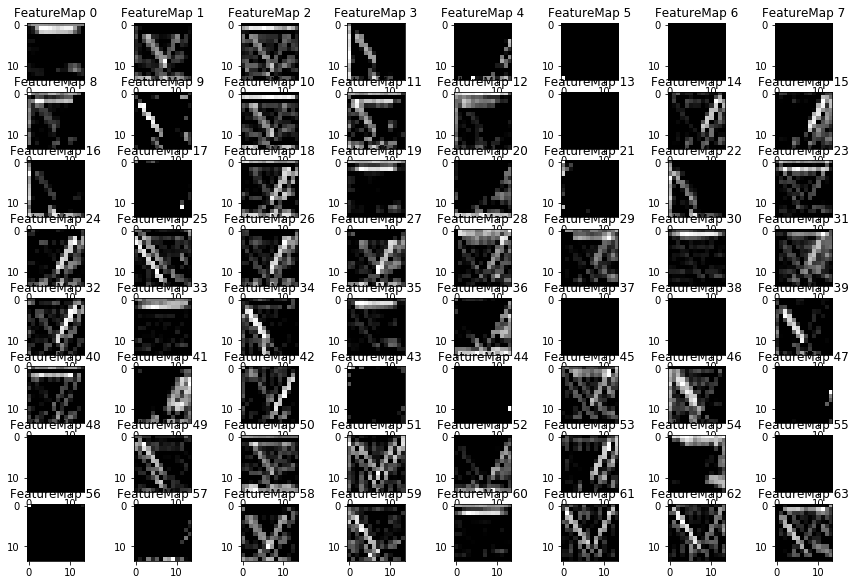

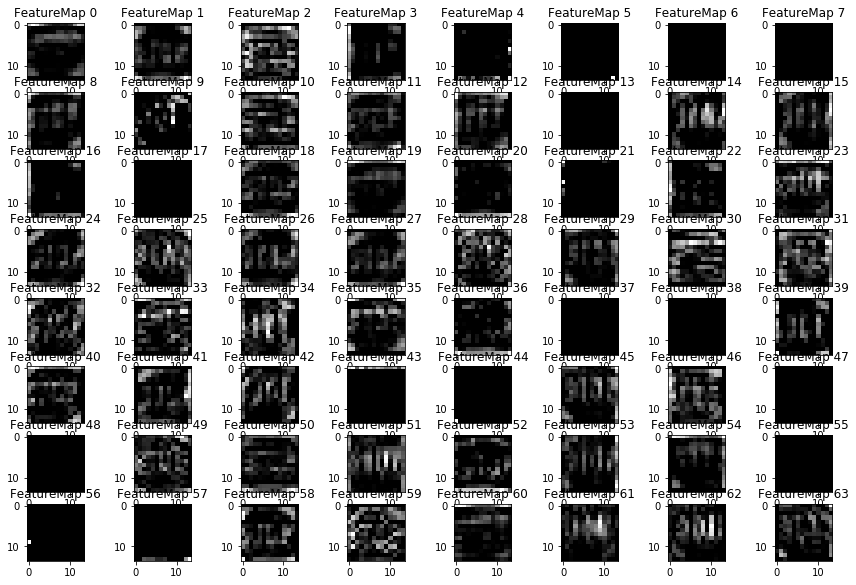

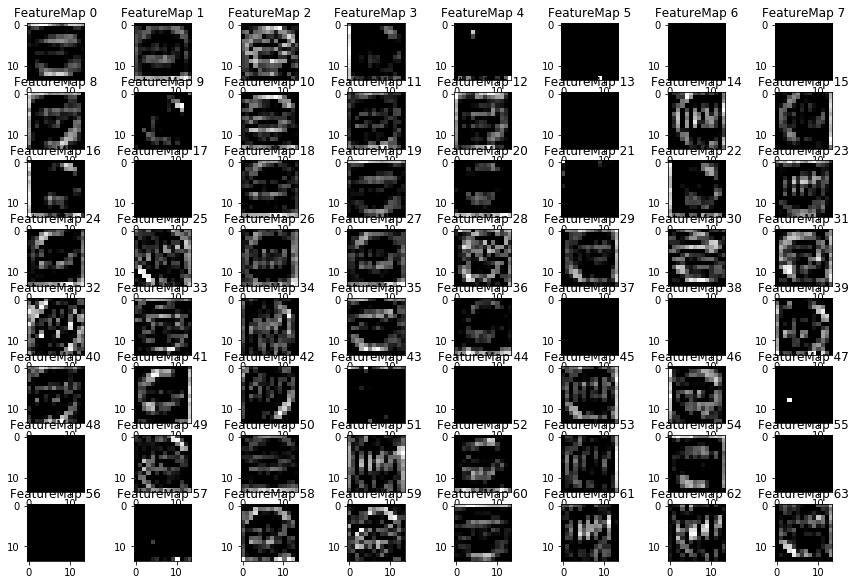

In [56]:

layerKey = "conv1"

with tf.Session() as sess:
    saver.restore(sess, MODEL_FILE)
        
    # Yield
    outputFeatureMap([extraPreproc[0]], layers[layerKey], plt_num=1)
        
    # Wrong Stop
    outputFeatureMap([extraPreproc[1]], layers[layerKey], plt_num=2)
    
    # OK Stop    
    outputFeatureMap([extraPreproc[5]], layers[layerKey], plt_num=3)